In [47]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import albumentations
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import joblib

from torch.utils.data import DataLoader, Dataset
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
from torchvision import transforms, datasets
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from torch.utils.tensorboard import SummaryWriter

### Data Loder

In [48]:
#https://debuggercafe.com/creating-efficient-image-data-loaders-in-pytorch-for-deep-learning/

In [49]:
transfrom=transforms.Compose([transforms.Resize(224),
                        transforms.CenterCrop(224),
                             transforms.ToTensor()])

In [50]:
class ImageDataset(Dataset):
    
    def __init__(self, path, labels, tfms=None):
        # data loading
        self.X = path
        self.y = labels
        
    def __getitem__(self, index):
        # dataset[0]
        image = Image.open(self.X[index]).convert('RGB')
        image = transfrom(image)
        #image = np.transpose(image, (2, 0, 1))
        type(image)
        label = self.y[index]
        return image, torch.tensor(label, dtype=torch.long)
        
    def __len__(self):
        # len(dataset)
        return(len(self.X))
    

### Model(DensNet)

In [51]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

In [52]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = torch.cat((X, Y), dim=1)
        return X

In [53]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [54]:
b1 = nn.Sequential(
    nn.Conv2d(3, 224, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(224), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [55]:
num_channels, growth_rate = 224, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # This is the number of output channels in the previous dense block
    num_channels += num_convs * growth_rate
    # A transition layer that haves the number of channels is added between
    # the dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

### Model Traning

In [56]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [57]:
def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
           torch.nn.init.xavier_uniform_(m.weight)

In [58]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveMaxPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 2))

In [59]:
#create TensorBorad
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(comment="test_old_Text_analyst")

In [60]:
df = pd.read_csv('../input/data.csv')
X_ = df.image_path.values
y_ = df.target.values

In [61]:
#TODO Splite data on train and test
(xtrain, xtest, ytrain, ytest) = train_test_split(X_, y_,test_size=0.25, random_state=42)


In [62]:
train_dataset = ImageDataset(xtrain, ytrain, 0)

In [64]:
def train(num_epochs, lr_list, batch_size_list):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    for batch_size in batch_size_list:
       for lr in lr_list:
          net = nn.Sequential(
               b1, *blks,
               nn.BatchNorm2d(num_channels), nn.ReLU(),
               nn.AdaptiveMaxPool2d((1, 1)),
               nn.Flatten(),
               nn.Linear(num_channels, 2))

   
          train_data = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
          writer = SummaryWriter(comment=f' batch_size={batch_size} lr={lr}')
          optimizer = torch.optim.SGD(net.parameters(), lr=lr)
          net.apply(init_weights)
          print('training on batch_size={batch_size}, lr={lr} and ', device)
          net.to(device)
          optimizer = torch.optim.SGD(net.parameters(), lr=lr)
          loss = nn.CrossEntropyLoss()
          for epoch in range(num_epochs):
             running_loss = 0.0
             running_correct = 0
        # Sum of training loss, sum of training accuracy, no. of examples
             for i ,(X, y) in enumerate(train_data):
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                y_hat = net(X)

                l = loss(y_hat, y)
                running_loss += l.item()*batch_size
                running_correct += get_num_correct(y_hat, y)
            
                l.backward()
                optimizer.step()
             #fore Tensorborad
            

             writer.add_scalar('training loss',
                     running_loss,
                     epoch)
             writer.add_scalar('training correct',
                     running_correct,
                     epoch)
             # log the epoch accuracy
             writer.add_scalar('training accuracy',
                      running_correct/len(train_data),
                      epoch)
        
             for name, weight in net.named_parameters():
                writer.add_histogram(name,weight, epoch)
                writer.add_histogram(f'{name}.grad',weight.grad, epoch)
        
             print(f"Epoch {epoch+1} train loss: {running_loss/len(train_data):.3f} train acc: {running_correct/len(train_data)}")
    print('Finished Training')

In [65]:
batch_size_list = [5, 10, 20]
lr_list = [.01, .001, .0001, .00001]
num_epochs = 10
train(num_epochs, lr_list, batch_size_list)
torch.save(net.state_dict(), 'mlp.params')

training on cpu
Epoch 1 train loss: 5.706 train acc: 3.4
Epoch 2 train loss: 4.024 train acc: 3.9
Epoch 3 train loss: 0.670 train acc: 4.5
Epoch 4 train loss: 0.495 train acc: 4.4
Epoch 5 train loss: 0.451 train acc: 4.5
Epoch 6 train loss: 0.145 train acc: 4.7
Epoch 7 train loss: 0.039 train acc: 4.7
Epoch 8 train loss: 0.017 train acc: 4.7
Epoch 9 train loss: 0.014 train acc: 4.7
Epoch 10 train loss: 0.013 train acc: 4.7
training on cpu
Epoch 1 train loss: 4.211 train acc: 3.2
Epoch 2 train loss: 2.107 train acc: 3.7
Epoch 3 train loss: 0.973 train acc: 4.4
Epoch 4 train loss: 0.255 train acc: 4.7
Epoch 5 train loss: 0.085 train acc: 4.7
Epoch 6 train loss: 0.064 train acc: 4.7
Epoch 7 train loss: 0.054 train acc: 4.7
Epoch 8 train loss: 0.047 train acc: 4.7
Epoch 9 train loss: 0.042 train acc: 4.7
Epoch 10 train loss: 0.038 train acc: 4.7
training on cpu
Epoch 1 train loss: 5.142 train acc: 2.0
Epoch 2 train loss: 1.814 train acc: 4.0
Epoch 3 train loss: 0.838 train acc: 4.7
Epoch 4

### Evaluation Model

In [77]:
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=20)
net = nn.Sequential(
               b1, *blks,
               nn.BatchNorm2d(num_channels), nn.ReLU(),
               nn.AdaptiveMaxPool2d((1, 1)),
               nn.Flatten(),
               nn.Linear(num_channels, 2))

In [78]:
writer = SummaryWriter(comment="best_old_Text_analyst")

In [79]:
def train(net, train_iter, num_epochs, lr):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
           torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
         running_loss = 0.0
         running_correct = 0
        # Sum of training loss, sum of training accuracy, no. of examples
         for i ,(X, y) in enumerate(train_data):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)

            l = loss(y_hat, y)
            running_loss += l.item()
            running_correct += get_num_correct(y_hat, y)
            
            l.backward()
            optimizer.step()
            #fore Tensorborad
            

         writer.add_scalar('training loss',
                    running_loss,
                    epoch)
         writer.add_scalar('training correct',
                    running_correct,
                    epoch)
        # log the epoch accuracy
         writer.add_scalar('training accuracy',
                    running_correct/len(train_data),
                    epoch)
        
         for name, weight in net.named_parameters():
           writer.add_histogram(name,weight, epoch)
           writer.add_histogram(f'{name}.grad',weight.grad, epoch)
        
         print(f"Epoch {epoch+1} train loss: {running_loss/len(train_data):.3f} train acc: {running_correct/len(train_data)}")
    print('Finished Training')
train(net, train_data, 10, 0.001)

training on cpu
Epoch 1 train loss: 0.789 train acc: 9.0
Epoch 2 train loss: 0.192 train acc: 16.0
Epoch 3 train loss: 0.058 train acc: 16.0
Epoch 4 train loss: 0.034 train acc: 16.0
Epoch 5 train loss: 0.026 train acc: 16.0
Epoch 6 train loss: 0.022 train acc: 16.0
Epoch 7 train loss: 0.019 train acc: 16.0
Epoch 8 train loss: 0.017 train acc: 16.0
Epoch 9 train loss: 0.016 train acc: 16.0
Epoch 10 train loss: 0.015 train acc: 16.0
Finished Training


In [80]:
def create_confusion_matrix(y_true, y_predicted):
    return confusion_matrix(y_true, y_predicted)

In [81]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.get_cmap('Blues')): 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    fig =plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(ticks=range(cm.min(), cm.max() + 1))

    target_names = ['0', '1']
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, "{:,}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True value')
    plt.xlabel('Predicted value\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    writer.add_figure(title, fig)

In [82]:
train_dataset = ImageDataset(xtrain, ytrain, 0)
train_data = torch.utils.data.DataLoader(train_dataset)

In [83]:
#X = []
#y = []
net.to('cpu')
y_true = []
y_predicted = []
softmax = nn.Softmax(dim=1)
for (image, label) in train_data:
    y_true.append(label.detach())
    y_predicted_tensor = net(image)
    y_predicted_tensor = softmax(y_predicted_tensor)
    y_predicted.append(torch.max(y_predicted_tensor, 1)[1])

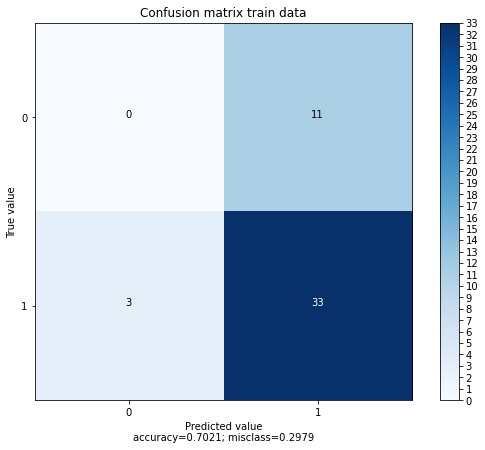

In [84]:
cm = create_confusion_matrix(y_true, y_predicted)
plot_confusion_matrix(cm, 'Confusion matrix train data')

In [85]:
train_dataset = ImageDataset(xtest, ytest, 0)
train_data = torch.utils.data.DataLoader(train_dataset)

In [86]:
net.to('cpu')
y_true = []
y_predicted = []
softmax = nn.Softmax(dim=1)
for (image, label) in train_data:
    y_true.append(label.detach())
    y_predicted_tensor = net(image)
    y_predicted_tensor = softmax(y_predicted_tensor)
    y_predicted.append(torch.max(y_predicted_tensor, 1)[1])

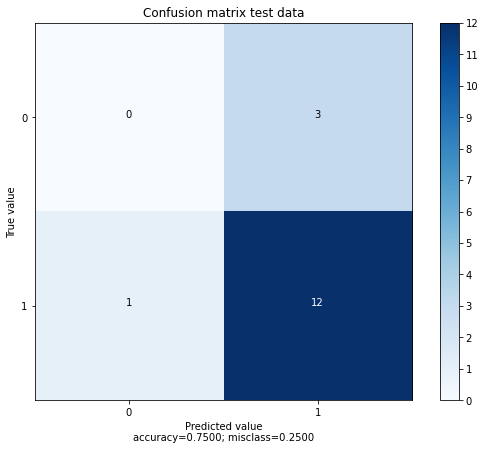

In [87]:
cm = create_confusion_matrix(y_true, y_predicted)
plot_confusion_matrix(cm, 'Confusion matrix test data')

In [88]:
dataiter = iter(train_data)
images, labels = dataiter.next()


In [89]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


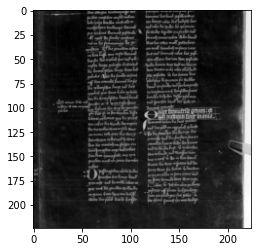

In [90]:
# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('old_text_image_images', img_grid)
net.to('cpu')
writer.add_graph(net, images)